# Overview of the identified links between institutions

#### General approach: use dedupe with multiple features
- cng: name, city
- mag: name, lat/lon
- nsf: name, city name (quality unclear)
- proquest: try to extract state from "location"

In [43]:

import sqlite3 as sqlite
import pandas as pd

from src.dataprep.helpers.variables import db_file

import matplotlib.pyplot as plt




To do 
- run another labelling step
- export ipynb to pdf
- continue with cng -> proquest and cng -> nsf, based on data here
- https://mcdc.missouri.edu/applications/zipcodes/ZIP_codes_2020.xls for downloading the zip code file. add somehwere in pipeline
- at the moment, we are not considering university hospitals etc. should we?

Load in data

In [44]:
# ## mag sample: Check institutions and names
con = sqlite.connect(db_file)

with con:
    query = """SELECT AffiliationId
                    , NormalizedName
                    , PublicationCount
                    , Latitude
                    , Longitude
                FROM affiliations
                INNER JOIN affiliation_outcomes using(AffiliationId)
                WHERE Iso3166Code = 'US' """
    mag = pd.read_sql(sql=query, con=con)

    query = """SELECT unitid
                , normalizedname
                , latitude
                , longitude
                , basic2021
                FROM cng_institutions"""
    cng = pd.read_sql(sql=query, con=con)

    query = """SELECT AffiliationId, unitid, link_score
             FROM institution_links 
             WHERE datasets = 'mag_cng' """
    links = pd.read_sql(sql=query, con=con)

con.close()


In [45]:
links = (links
        .set_index("AffiliationId")
        .join(mag.loc[:, ["AffiliationId", "NormalizedName", "Latitude", "Longitude"]]
            .set_index("AffiliationId")
        )
        .reset_index()
        .set_index(["unitid"])
        .join(cng.loc[:, ["unitid", "normalizedname", "basic2021", "latitude", "longitude"]]
            .set_index("unitid")
        )
        .reset_index()
    )


Histogram of link_score

Text(0.5, 0, 'Linking score')

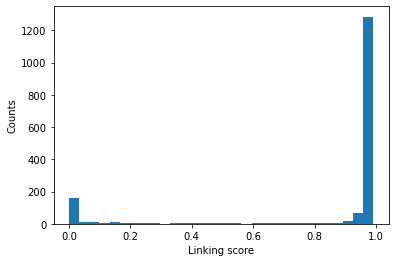

In [46]:
plt.hist(links["link_score"], bins=30) 
plt.ylabel('Counts')
plt.xlabel('Linking score')


Inspect links with low scores
- The linking score may be low, but the lat-lon matching seems to work pretty well. So we can allow for a relatively low threshold

In [47]:
mask = links["link_score"] > 0.1

links = links.loc[mask, :]

links.shape
links.unitid.nunique()
links.AffiliationId.nunique()

1488

In [48]:
links.loc[mask, :].sort_values("link_score").head(10)

# mask = (links.NormalizedName.str.contains("rutgers") ) & (links["link_score"] > 0.03)

# links.loc[mask, :].head()


,unitid,AffiliationId,link_score,NormalizedName,Latitude,Longitude,normalizedname,basic2021,latitude,longitude
1487,137847.0,9.332026e+07,0.101827,university of tampa,27.947157,-82.465355,the university of tampa,18,28.127001,-82.353996
1486,190567.0,1.291576e+09,0.103649,trinity evangelical lutheran church of manhattan,40.796180,-73.968124,city university of new york,16,40.799000,-73.967003
1485,189228.0,1.699400e+08,0.114524,bank street college of education,40.805560,-73.966390,berkeley college new york,22,40.799000,-73.967003
1484,204699.0,2.801551e+09,0.131857,the ohio state university at marion,40.581530,-83.089210,ohio state university marion campus,23,40.598999,-83.129997
1483,480198.0,2.801505e+09,0.132984,warner pacific college,45.506000,-122.593000,warner pacific university professional and gra...,22,45.550999,-122.808998
1482,193292.0,1.769227e+08,0.133675,molloy college,40.685830,-73.626390,molloy university,18,40.666000,-73.638000
1481,173045.0,1.199161e+08,0.135346,augsburg college,44.965900,-93.241600,augsburg university,18,44.935001,-93.252998
1480,159568.0,5.116225e+07,0.135876,louisiana college,31.326283,-92.427140,louisiana christian university,20,31.327999,-92.355003
1479,190637.0,1.034971e+08,0.136060,state university of new york at purchase,41.047283,-73.702125,city university of new york,18,40.869999,-73.865997
1478,204680.0,2.800774e+09,0.137145,the ohio state university at mansfield,40.798890,-82.577780,ohio state university mansfield campus,23,40.776001,-82.528000


In [49]:

mask = (~cng["unitid"].isin(links["unitid"]))
cng.loc[mask, :].sort_values("basic2021").iloc[10:20, :].head()

cng.loc[mask, :].sort_values("basic2021").iloc[0:10]



,unitid,normalizedname,latitude,longitude,basic2021
208,126562,university of colorado denver anschutz medical...,39.695000,-105.036003,15
1533,233921,virginia polytechnic institute and state unive...,37.255001,-80.422997,15
958,186371,rutgers university camden,39.950001,-75.096001,16
882,199102,north carolina a t state university,36.000999,-79.764999,16
975,186399,rutgers university newark,40.723000,-74.139000,16
341,482149,augusta university,33.347000,-81.968002,16
317,133650,florida agricultural and mechanical university,30.452000,-84.352997,16
510,488679,indiana wesleyan university national global,40.519001,-85.644997,17
1353,251312,south university columbia,34.092999,-80.918999,17
1074,196592,touro university new york,40.799000,-73.967003,17


In [50]:
mag.head()
mask = (~mag["AffiliationId"].isin(links.AffiliationId)) \
            & (mag.NormalizedName.str.contains("university|college")) \
            & (~mag.NormalizedName.str.contains("medical|medicine|health|hospital|cancer"))


display(mag.loc[mask, :].sort_values("PublicationCount", ascending=False).iloc[0:10])


,AffiliationId,NormalizedName,PublicationCount,Latitude,Longitude
8073,921990950,university of colorado denver,55179,39.743460,-105.003120
594,2803209242,university of california,30791,37.802170,-122.271278
3102,1331384533,university of hawaii,30271,21.297000,-157.817000
1363,25041050,georgia regents university,28840,33.471700,-81.988850
6037,184983240,northeast normal university,18596,34.072224,-118.444100
8432,118292597,national taipei university of technology,12840,34.072224,-118.444100
1482,182273258,florida state university college of arts and s...,11375,30.440428,-84.296370
1194,127339247,california state university,10612,33.763890,-118.201111
2487,192389796,humboldt state university,9866,40.875782,-124.078560
4477,2802946424,johns hopkins university applied physics labor...,8226,39.165280,-76.897220


In [51]:
print("Done.")

Done.
